In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout, Conv1D, MaxPool1D
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
df = pd.read_csv('data.csv')

y = df["category"].values
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in df["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

In [4]:
y

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [6]:
X1 = X.copy()
X1

[['washington',
  'reuters',
  'head',
  'conservative',
  'republican',
  'faction',
  'congress',
  'voted',
  'month',
  'huge',
  'expansion',
  'national',
  'debt',
  'pay',
  'tax',
  'cuts',
  'called',
  'fiscal',
  'conservative',
  'sunday',
  'urged',
  'budget',
  'restraint',
  '2018',
  'keeping',
  'sharp',
  'pivot',
  'way',
  'among',
  'republicans',
  'representative',
  'mark',
  'meadows',
  'speaking',
  'cbs',
  'face',
  'nation',
  'drew',
  'hard',
  'line',
  'federal',
  'spending',
  'lawmakers',
  'bracing',
  'battle',
  'january',
  'return',
  'holidays',
  'wednesday',
  'lawmakers',
  'begin',
  'trying',
  'pass',
  'federal',
  'budget',
  'fight',
  'likely',
  'linked',
  'issues',
  'immigration',
  'policy',
  'even',
  'november',
  'congressional',
  'election',
  'campaigns',
  'approach',
  'republicans',
  'seek',
  'keep',
  'control',
  'congress',
  'president',
  'donald',
  'trump',
  'republicans',
  'want',
  'big',
  'budget',
  '

In [7]:
import gensim

EMBEDDING_DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=EMBEDDING_DIM, window=5, min_count=1)

In [8]:
#vocab size
len(w2v_model.wv.key_to_index)

118464

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

In [10]:
maxlen = 300 
X = pad_sequences(X, maxlen=maxlen)

In [11]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)
embedding_vectors.shape

(118465, 100)

In [12]:
X.shape

(44889, 300)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, y) 

In [23]:
data = []

for row in X1:
    tmp = 0
    l = 0
    for element in row:
        #print(element)
        l += 1
        tmp += w2v_model.wv[element]
    tmp /= l
    data.append(tmp)
    #print(tmp.dtype)

data = np.array(data)
#np.save(f'Word2Vec_X.npy', data)
#np.save(f'y.npy', y)

# LSTM

In [15]:
batch_size = 256
epochs = 10
embed_size = 100
max_features = 10000

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=embed_size, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          11846500  
                                                                 
 lstm (LSTM)                 (None, 300, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12015269 (45.83 MB)
Trainable params: 168769 (659.25 KB)
Non-trainable params: 11846500 (45.19 MB)
_________________________________________________________________


In [17]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (x_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10



132/132 [==============================] - 636s 5s/step - loss: 0.1302 - accuracy: 0.9520 - val_loss: 0.0432 - val_accuracy: 0.9847 - lr: 0.0010
Epoch 2/10
132/132 [==============================] - 702s 5s/step - loss: 0.0474 - accuracy: 0.9844 - val_loss: 0.0433 - val_accuracy: 0.9870 - lr: 0.0010
Epoch 3/10
132/132 [==============================] - 732s 6s/step - loss: 0.0334 - accuracy: 0.9886 - val_loss: 0.0280 - val_accuracy: 0.9908 - lr: 0.0010
Epoch 4/10
132/132 [==============================] - 762s 6s/step - loss: 0.0289 - accuracy: 0.9903 - val_loss: 0.0268 - val_accuracy: 0.9914 - lr: 0.0010
Epoch 5/10
132/132 [==============================] - 750s 6s/step - loss: 0.0210 - accuracy: 0.9926 - val_loss: 0.0190 - val_accuracy: 0.9938 - lr: 0.0010
Epoch 6/10
132/132 [==============================] - 754s 6s/step - loss: 0.0139 - accuracy: 0.9950 - val_loss: 0.0180 - val_accuracy: 0.9946 - lr: 0.0010
Epoch 7/10
132/132 [==============================] - 798s 6s/step - loss: 

In [19]:
y_pred = model.predict(x_test)

351/351 [==============================] - 17s 47ms/step


In [32]:
threshold = 0.5
y_pred_binary = (np.squeeze(y_pred) > threshold).astype(int)
y_pred_binary.shape

(11223,)

In [33]:
y_pred.dtype

dtype('float32')

In [30]:
y_test.shape

(11223,)

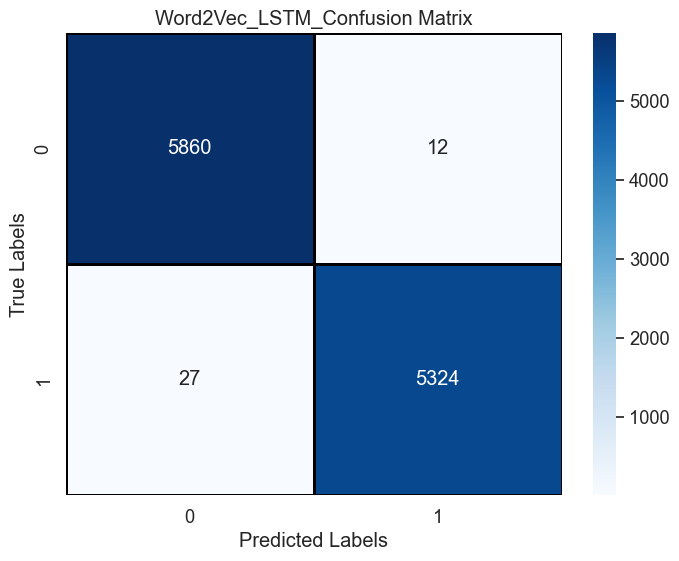

Accuracy: 0.9965249933172948


In [36]:
cm = confusion_matrix(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=2, linecolor="black")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Word2Vec_LSTM_Confusion Matrix")

plt.show()

print(f"Accuracy: {accuracy}")